# Time dependant solutions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as q 

## Strongly driven Rabi oscillations - non RWA

All the above is relatively simply and can be calculated analytically. But this becomes much more difficult when the rotating wave approximation (RWA) fails.
Here we look at the situation of strong driving, where $\Omega_1 \approx \omega_s$.\
$H(t) = \omega_s S_z + \Omega_1 \cos(\omega t) S_x$ \
\
In qutip the Hamiltonian is seperated in $H(t) = H_0 + H_1(t)$.

Text(0, 0.5, 'exp. value')

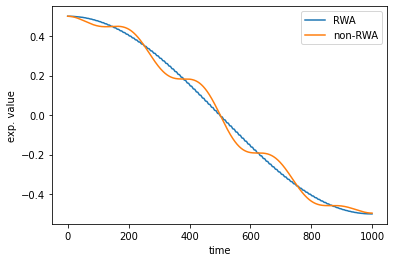

In [4]:
#Define the operators 1/2
sz = q.sigmaz() * 0.5
sx = q.sigmax() * 0.5
sy = q.sigmay() * 0.5


Omegas = [0.02,0.5]

plot_types = ['Rabi','ODMR']
plot_type = 'Rabi'

labels = ['RWA','non-RWA']
odmrs = []
for j in range(2):
    #Physical frequencies
    Omega = Omegas[j]
    Omega *= 2 * np.pi
    omegas = 1 * 2 * np.pi

    # NV hamiltonian
    H0 = omegas * sz
    Hx1 = Omega * sx 

    def Hx1_coeff(t,args):
        delta = args['wp'] 
        phase = args['phase']
        return np.cos(1*delta * t + phase)

    H = [H0,[Hx1,Hx1_coeff]]

    #simulation parameters
    time_x=4*np.pi/Omega
    npoints = 1000
    t = np.linspace(0, time_x, npoints)

    #initial state - rho
    phi = q.basis(2,0)

    rho_nv = phi*phi.dag()
    odmr_frq = []
    odmr = []
    for k,omega in enumerate([np.pi*2]):
        wp = omega
        phase=0
        odmr_frq.append(wp/(2*np.pi))
        output = q.mesolve(H=H, rho0=rho_nv, tlist=t, c_ops = [], e_ops=[], 
                           options=q.Options(nsteps=100000), args={'wp':wp ,'phase': phase})
        odmr.append(q.expect(output.states, sz)[-1])
        
        if wp == omegas:
            plt.plot(q.expect(output.states, sz),label=labels[j])
    odmrs.append(odmr)
plt.legend()
plt.xlabel('time')
plt.ylabel('exp. value')

## Floquet dynamics under strong longitudinal drive

Another interesting case of time dependant Hamiltonians are Floquet dynamics (periodic in time Hamiltonians),
here as a strong longitudinal drive. It allows to make controlable sideband transitions, e.g. Childress, Lukin,\
\
$H = D S_z^2 + \frac{\omega_0}{2}  \,S_z + \frac{\Omega_{rf}}{2}  \,cos(\omega_{rf}t) S_z  + \Omega_1 \, \cos(\omega_1 t) \, \sigma_x$ 




In [8]:
#Static Part

#Frequencies
Omega = 1
Omega *= 2 * np.pi

# NV hamiltonian
sx = q.spin_Jx(0.5)
sy = q.spin_Jy(0.5)
sz = (q.qeye(2) - q.sigmaz() )*0.5

sz2 = (-q.qeye(2) + q.sigmaz()) *0.5


#resonance frequency 
ws = 0.01e3 
D = 2.87e3  
def get_Hdc():
    Hdc = ws * sz * 2 * np.pi+ D* sz2 * 2 * np.pi
    return Hdc
get_Hdc()



Hdc = get_Hdc()
Hdc

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[     0.              0.        ]
 [     0.         -17969.90997853]]

In [9]:
Omega = 2 #MHz
Omegarf = 20 * 2 * np.pi

#time independant
Hdc = get_Hdc() #MHz

#time dependant
H1 = Omega * sx * 2 * np.pi
Hrf = Omegarf * sz

#time dependant functions
def Hx1_coeff(t,args):
    freq = args['freq1']
    amp = args['amp1']
    return amp * np.sin(2 * np.pi *freq * t)



def Hxprobe_coeff(t,args):
    freq = args['freqp'] 
    phase = args['phasep']
    amp = args['ampp']
    return amp *  np.sin(2 * np.pi *freq * t + phase)


#Overall Hamiltonian
H = [Hdc,[H1,Hxprobe_coeff],[Hrf,Hx1_coeff],]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 0.]
 [0. 1.]]


  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

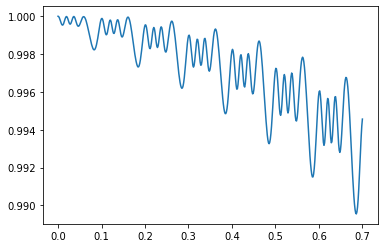

In [12]:
#initial state
phi = q.basis(2,1)
rho_nv = phi*phi.dag()
print(rho_nv)



#odmr start/stop/points
startf = -40
stopf = 40
length= 61
freqs  = np.linspace(startf,stopf,length)


#Floquet frequency and phase
wrf = 10
phase = 0


#result outputs
odmr_frq = []
odmr = []
floquet = []


from tqdm import notebook
for j in range(2):
    for k in notebook.tqdm(range(length)):
        wodmr = freqs[k] + 2860
        if j == 0:
            time_x= 0.5
            t = np.linspace(0, time_x, 500)
            odmr_frq.append(wodmr)
            output = q.mesolve(H=H, rho0=rho_nv, tlist=t, c_ops = [], e_ops=[], 
                               options=q.Options(nsteps=100000), args={'freqp': wodmr, 'phasep': phase, 'freq1':wrf,
                                                                      'ampp':1,'amp1':0})
            odmr.append(q.expect(output.states, sz)[-1])
        else:
            time_x= 0.7
            t = np.linspace(0, time_x, 500)
            output = q.mesolve(H=H, rho0=rho_nv, tlist=t, c_ops = [], e_ops=[], 
                               options=q.Options(nsteps=100000), args={'freqp': wodmr, 'phasep': phase, 'freq1':wrf,
                                                                      'ampp':1,'amp1':1})
            floquet.append(q.expect(output.states, sz)[-1])
plt.plot(t,q.expect(output.states, sz))

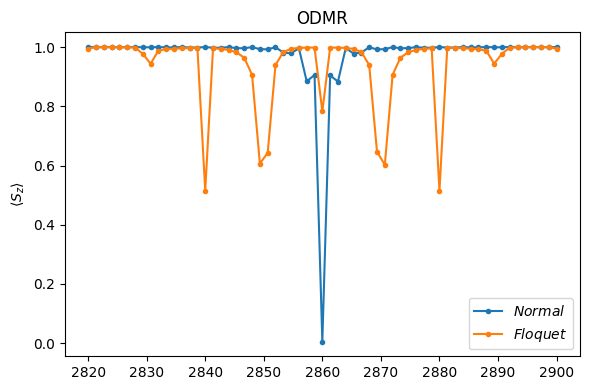

In [13]:
plt.figure(dpi = 100)

plt.title('ODMR')
plt.plot(odmr_frq,np.asarray(odmr),marker = '.', linestyle = '-',label='$Normal$')
plt.plot(odmr_frq,np.asarray(floquet),marker = '.', linestyle = '-',label='$Floquet$')
plt.legend(loc=4)
plt.ylabel('$\\langle S_z \\rangle$')

comment = f'$\\omega_0 = 2860 \\pm {ws} $'
comment += '\n'
comment += f'$\\omega_x = {wrf}$'
comment += '\n'
comment += f'$\\Omega_x = {np.round(Omegarf)}$'


#plt.text(2855, -0.1, comment, fontsize=14,
#        verticalalignment='top')
#plt.ylim([-1.05,1.05])

plt.tight_layout()
plt.savefig('odmr-and-floquet-odmr.png')